# Task 2: RNN application -- Tweet Sentiment Analysis

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [3]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [4]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [5]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [6]:
# Training function
num_steps = train_tweets.shape[0]//batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size 
        end = start + batch_size

        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})

        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                
            print("step: ",step," test accuracy = ",(test_acc/test_batches))
            

step:  0  test accuracy =  0.553125
step:  50  test accuracy =  0.64375
step:  100  test accuracy =  0.684375
step:  150  test accuracy =  0.702083333333
step:  200  test accuracy =  0.715625
step:  250  test accuracy =  0.728125
step:  300  test accuracy =  0.730208333333
step:  350  test accuracy =  0.708333333333
step:  400  test accuracy =  0.732291666667
step:  450  test accuracy =  0.739583333333
step:  500  test accuracy =  0.741666666667
step:  550  test accuracy =  0.741666666667
step:  600  test accuracy =  0.711458333333
step:  650  test accuracy =  0.751041666667
step:  700  test accuracy =  0.758333333333
step:  750  test accuracy =  0.75
step:  800  test accuracy =  0.746875
step:  850  test accuracy =  0.752083333333
step:  900  test accuracy =  0.746875


### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [7]:
# YOUR DOUBLE-LAYER LSTM Here
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
num_layers = 2

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
# lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(hidden_size) for i in range(num_layers)])

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)


In [8]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0]//batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start = step*batch_size
        end = start + batch_size
                
        batch_tweet = train_tweets[start:end]
        batch_label = train_labels[start:end]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict={tweets:batch_tweet,labels:batch_label})

        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                l = i*batch_size
                r = l + batch_size
                test_X = test_tweets[l:r]
                test_Y = test_labels[l:r]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
            print("step: ",step," test accuracy = ",(test_acc/test_batches))

step:  0  test accuracy =  0.54375
step:  50  test accuracy =  0.644791666667
step:  100  test accuracy =  0.676041666667
step:  150  test accuracy =  0.708333333333
step:  200  test accuracy =  0.719791666667
step:  250  test accuracy =  0.74375
step:  300  test accuracy =  0.741666666667
step:  350  test accuracy =  0.73125
step:  400  test accuracy =  0.751041666667
step:  450  test accuracy =  0.740625
step:  500  test accuracy =  0.747916666667
step:  550  test accuracy =  0.747916666667
step:  600  test accuracy =  0.733333333333
step:  650  test accuracy =  0.755208333333
step:  700  test accuracy =  0.7625
step:  750  test accuracy =  0.757291666667
step:  800  test accuracy =  0.746875
step:  850  test accuracy =  0.747916666667
step:  900  test accuracy =  0.745833333333


## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [9]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    embedding_mat = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0),name = name)
    embed_lookup = tf.nn.embedding_lookup(embeddings, input_)
    return embedding_mat,embed_lookup
# YOUR CODE HERE

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [10]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
output_size = 150


# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

embedding_mat, lookup = embedding(tweets,vocab_size,output_size,'embedding_mat')

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, lookup, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [11]:
# YOUR TRAINING HERE
num_steps = train_tweets.shape[0] // batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        
        start_idx = step*batch_size
        end_idx = start_idx + batch_size
        

        batchX = train_tweets[start_idx:end_idx]
        batchY = train_labels[start_idx:end_idx]
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss, acc],feed_dict= \
                                                {tweets:batchX,labels:batchY})

        if (step % 50 == 0):
            test_batches = test_tweets.shape[0] // batch_size
            test_acc = 0
            for i in range(test_batches):
                idx1 = i*batch_size
                idx2 = idx1 + batch_size
                test_X = test_tweets[idx1:idx2]
                test_Y = test_labels[idx1:idx2]
                test_acc += sess.run(acc,feed_dict= {tweets:test_X,labels:test_Y})
                
            print("step: ",step," test accuracy = ",(test_acc/test_batches))
            # TODO: get test accuracy and loss, and print them out.
    vocab_embeddings = sess.run(embedding_mat)

step:  0  test accuracy =  0.519791666667
step:  50  test accuracy =  0.553125
step:  100  test accuracy =  0.548958333333
step:  150  test accuracy =  0.608333333333
step:  200  test accuracy =  0.659375
step:  250  test accuracy =  0.664583333333
step:  300  test accuracy =  0.682291666667
step:  350  test accuracy =  0.7
step:  400  test accuracy =  0.728125
step:  450  test accuracy =  0.735416666667
step:  500  test accuracy =  0.736458333333
step:  550  test accuracy =  0.751041666667
step:  600  test accuracy =  0.723958333333
step:  650  test accuracy =  0.75
step:  700  test accuracy =  0.751041666667
step:  750  test accuracy =  0.751041666667
step:  800  test accuracy =  0.741666666667
step:  850  test accuracy =  0.754166666667
step:  900  test accuracy =  0.7625


### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [15]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
#fruit_clour = ["apple", "red", "lemon", "yellow", "mandarin", "orange"]

vocab_embeddings.shape

(7597, 150)

In [16]:
from sklearn.manifold import TSNE
### your code here
X_embedded = TSNE( n_components=2, init='pca', n_iter=1000, random_state=10).fit_transform(vocab_embeddings)
X_embedded.shape

(7597, 2)

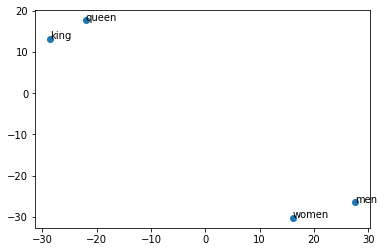

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def wordvec(vocab,words):
    idx = [np.where(vocab==a) for a in words]
    res = []
    for i in range(len(idx)):
        res.append(idx[i][0][0])
    return res
X = X_embedded[wordvec(vocabulary,female_male)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(female_male):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()



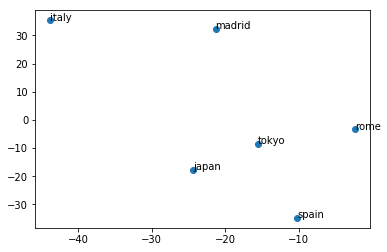

In [18]:
X = X_embedded[wordvec(vocabulary,country_capital)]

plt.scatter(X[:,0],X[:,1])

for i, txt in enumerate(country_capital):
    plt.annotate(txt, (X[i,0],X[i,1]))
plt.show()

#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: **We see in the above two example that the vectors joining the words men-women and king-queen seem to be parallel. This however is not completely true in the second case. The vectors seem to be dispriented in a random way. **